In [2]:
import keras

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
#from keras.layers import CategoryEncoding
import keras_tuner as kt

import os,io

import tensorflow as tf

import chess
import chess.pgn
from chess.engine import PovScore, Mate, Cp

from io import StringIO

import random

import numpy as np

NUM_MOVES = 40 #number of moves to store in tensor

In [33]:
def get_ratings(game):

    return int(game.headers['WhiteElo']),int(game.headers['BlackElo'])

def rating_to_output(rating):
    ret = np.zeros(48)
    r = int((rating-600)/50)
    if r>47:
        r = 47
    if r<0:
        r = 0
    ret[r] = 1
    return ret

def make_game_tensor(game,num_moves):
  #print(game)
  gt1 = np.zeros((num_moves,136))
  gt2 = np.zeros((num_moves,136))
  #we will make two game tensors from a game, one for each player. 
  #The tensor will be a 136 element tensor. The first 64 elements will be the board state, the next 64 will be the board state after the move. Element 129
  # is the move number. Element 130 is the time on the clock at the start of the move and element 131 is the time on the clock after the move. Element 132 is the time on the clock of the opponent.
  #Element 133 is the evaluation of the position before the move and 134 is the evaluation of the position after the move. Element 135 is a 1 if the evaluation before the move is a mate in ... and 0 otherwise while element 136 is a 1 if the evaluation after the move is a mate in ... and 0 otherwise.

  #The board state itself is a 64 element tensor with 0 for empty spaces, 1...6 for the current color's pieces and 7...12 for the opponent's pieces. 
  board = game.board()
  white_time = 300
  black_time = 300

  move_number = 0

  current_eval = PovScore(Cp(0), chess.WHITE)
  current_move_color = chess.WHITE #start with white

  while True:
  
    t = np.zeros(136)

    for i in range(64):
        if board.piece_at(i)==None:
          t[i] = 0
        elif board.piece_at(i).color == current_move_color:
           t[i] = board.piece_at(i).piece_type
        else:
           t[i] = board.piece_at(i).piece_type+7
      
    #get the evaluation, time etc.

    t[128] = move_number//2 #move number

    t[129] = white_time if current_move_color == chess.WHITE else black_time
  
    t[131] = black_time if current_move_color == chess.WHITE else white_time
  
    if current_eval.pov(current_move_color).is_mate():
      t[133] = 1
      t[132] = current_eval.pov(current_move_color).mate()
    else:
      t[133] = 0
      t[132] = current_eval.pov(current_move_color).score()

    m = game.next()
    if m == None:
      break

    if current_move_color == chess.WHITE:
      white_time = m.clock()
    else:
      black_time = m.clock()
      
    current_eval = m.eval()
    board = game.board()

    for i in range(64):
        if board.piece_at(i)==None:
          t[i+64] = 0
        elif board.piece_at(i).color == current_move_color:
          t[i+64] = board.piece_at(i).piece_type
        else:
          t[i+64] = board.piece_at(i).piece_type+7
  
    t[130] = white_time if current_move_color == chess.WHITE else black_time
  
    if current_eval.pov(current_move_color).is_mate():
      t[135] = 1
      t[134] = current_eval.pov(current_move_color).mate()
    else:
      t[135] = 0
      t[134] = current_eval.pov(current_move_color).score()

    if current_move_color == chess.WHITE:
      gt1[move_number//2] = t
    else:
      gt2[move_number//2] = t

    current_move_color = not current_move_color

    move_number+=1

    if move_number == num_moves*2:
      break

  return np.array(gt1),np.array(gt2)


In [4]:
def check_game(string):
    #checks if there is a string 'TimeControl "600+0"' in the game string, whether the string contains the string 'eval' and whether the string 'WhiteRatingDiff "X"' and 'BlackRatingDiff "Y"' are present and the absolute values of X and Y are less than 40.

    #print("GAME STRING:",string,"END GAME STRING")
    if string == "":
        return None

    if 'TimeControl "300+0"' in string and 'eval' in string and 'WhiteRatingDiff' in string and 'BlackRatingDiff' in string:
        white_diff = int(string.split('WhiteRatingDiff "')[1].split('"')[0])
        black_diff = int(string.split('BlackRatingDiff "')[1].split('"')[0])
        if abs(white_diff) < 40 and abs(black_diff) < 40:
            return True
        
    return False

def extract_games(source_file,target_file): 
    tf = open(target_file,'w')
    
    game = ""

    with open(source_file) as f:
        for line in f.readline():
            if line.startswith("[Event ") and game=="":
                game=line
            elif line.startswith("[Event "):
                if check_game(game):
                    tf.write(game)
                game = line
            else:
                game+=line

def extract_games_stdin(target_file): 
    tf = open(target_file,'w')
    
    game = ""

    for line in sys.stdin:
        if line.startswith("[Event ") and game=="":
            game=line
        elif line.startswith("[Event "):
            if check_game(game):
                tf.write(game)
            game = line
        else:
            game+=line
    

In [34]:
def make_data(game_file,path,target_file): #assumes that the game file is a pgn file with games that have the correct time control, evals and rating differences, see check_game function
    found_count = 0
    X,y, = [], []

    with open(game_file) as f:
        while True:
            game = chess.pgn.read_game(f)
            if game == None:
                break
            if game.headers['Termination'] == "Abandoned" or game.headers['Termination'] == "Rules infraction":
                continue
            y1,y2 = get_ratings(game)
            gt1,gt2 = make_game_tensor(game,num_moves=NUM_MOVES)
            X.append(gt1)
            X.append(gt2)
            y.append(y1)
            y.append(y2)
            found_count += 1
            if found_count % 1000 == 0:
                print("Found " + str(found_count) + " games")
                np.savez_compressed(os.path.join(path,target_file + "_X.npz"),np.array(X))
                np.savez_compressed(os.path.join(path,target_file + "_y.npz"),np.array(y))
                
            

    X = np.array(X)
    y = np.array(y)
    
    #save the data to the target file
    np.savez_compressed(os.path.join(path,target_file + "_X.npz"),X)
    np.savez_compressed(os.path.join(path,target_file + "_y1.npz"),y1)
    np.savez_compressed(os.path.join(path,target_file + "_y2.npz"),y2)

def load_data(path,target_file):
    X = np.load(os.path.join(path,target_file + "_X.npz"))["arr_0"]
    y1 = np.load(os.path.join(path,target_file + "_y1.npz"))["arr_0"]
    y2 = np.load(os.path.join(path,target_file + "_y2.npz"))["arr_0"]

    return X,y1,y2


#if the data doesn't exist, generate it
if not os.path.exists("data/all_data/data_X.npz"):
    make_data("data/all_data/extracted_games05.pgn","data/all_data/","data")

X,y1,y2 = load_data("data/all_data","data")

#X = simplify_data_eval_only(X)
#X = simplify_data_no_eval(X)

Found 1000 games
Found 2000 games
Found 3000 games
Found 4000 games
Found 5000 games
Found 6000 games
Found 7000 games
Found 8000 games
Found 9000 games
Found 10000 games
Found 11000 games
Found 12000 games
Found 13000 games
Found 14000 games
Found 15000 games
Found 16000 games
Found 17000 games
Found 18000 games
Found 19000 games
Found 20000 games
Found 21000 games
Found 22000 games
Found 23000 games
Found 24000 games
Found 25000 games
Found 26000 games
Found 27000 games
Found 28000 games
Found 29000 games
Found 30000 games
Found 31000 games
Found 32000 games
Found 33000 games
Found 34000 games
Found 35000 games
Found 36000 games
Found 37000 games
Found 38000 games
Found 39000 games
Found 40000 games
Found 41000 games
Found 42000 games
Found 43000 games
Found 44000 games
Found 45000 games
Found 46000 games
Found 47000 games
Found 48000 games
Found 49000 games
Found 50000 games
Found 51000 games
Found 52000 games
Found 53000 games
Found 54000 games
Found 55000 games
Found 56000 games
F

In [5]:
def bindata(X,y):
    bins = {}
    for i in range(len(y)):
        bin = int(y[i]/50)
        if bin not in bins:
            bins[bin] = []
        
        bins[bin].append((X[i],y[i]))
        
    return bins

def oversample(bins,num_samples):
    #pick a total of num_samples samples from the bins by selecting a bin from bins at random and then selecting a sample from that bin at random
    retX,retY = [],[]
    for i in range(num_samples):
        bin = random.choice(list(bins.keys()))
        sample = random.choice(bins[bin])
        retX.append(sample[0])
        retY.append(sample[1])

    return np.array(retX),np.array(retY)
    

In [7]:
def model_builder(hp):

    #inputs = Input(shape=(NUM_MOVES, 132)) #if no eval is used
    inputs = Input(shape=(NUM_MOVES, 137)) #full tensor
    #inputs = Input(shape=(NUM_MOVES,8)) #if only the eval is used
    
    x = inputs

    #prepare hyperparameter tuning

    num_LSTM_layers = hp.Int('num_LSTM_layers',0,2)
    num_LSTM_units=[]
    for i in range(num_LSTM_layers+1):
        num_LSTM_units.append(hp.Int('lstm'+str(i)+'_units',
                                     min_value = 32,
                                     max_value = 256,
                                     step=16))
        
                                     
    num_dense_layers = hp.Int('num_dense_layers',1,3)
    num_dense_units = []
    dense_activation = []

    for i in range(num_dense_layers):
        num_dense_units.append(hp.Int('dense'+str(i)+'_units',
                                     min_value = 32,
                                     max_value = 256,
                                     step=16))
        dense_activation.append(hp.Choice("dense"+str(i)+"_activation",["relu", "selu","leaky_relu","tanh"]))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-2])

    #make the NN

    for i in range(num_LSTM_layers):
        x = LSTM(num_LSTM_units[i],return_sequences = True)(x)

    #add a final LSTM layer that doesn't return sequences
    x = LSTM(num_LSTM_units[-1])(x)
    
    for i in range(num_dense_layers):
        x = Dense(num_dense_units[i],activation = dense_activation[i])(x)


    output = Dense(1,activation='relu',name="Elo")(x)
    

    #Alternative: set outputs to be hot encoded between 48 values
    #output1 = Dense(48,activation='softmax',name="WhiteElo")(x)
    #output2 = Dense(48,activation='softmax',name="BlackElo")(x)

    model = keras.Model(inputs=inputs,outputs=[output])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss={'Elo':'mae'},
                    metrics={'Elo':'mae'})

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True,mode='auto',monitor='val_loss')

tuner.search(X,y,epochs=100,validation_split=0.2,callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.values)

model = tuner.hypermodel.build(best_hps)

history = model.fit(X,y,epochs=100,validation_split=0.2,callbacks=[stop_early,save])
model.save('model3.keras')

In [21]:
#select 20% of the data to be used for validation

split = int(0.8*len(X))

X_train = X[:split]
y_train = y[:split]

X_val = X[split:]
y_val = y[split:]

bins = bin_data(X_train,y_train)
print("bins made")
OX,Oy = oversample(bins,len(X))

inputs = Input(shape=(NUM_MOVES, 136)) #full tensor
x = LSTM(80,return_sequences = True)(inputs)
x = LSTM(32)(x)
x = Dense(80,activation='relu')(x)

output1 = Dense(1,activation='relu',name="Elo")(x)

model = keras.Model(inputs=inputs,outputs=[output1])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'Elo':'mae'},
                    metrics={'Elo':'mae'})

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelO1W.keras', save_best_only=True,mode='auto',monitor='val_loss')

model.fit(OX,Oy1,epochs=100,validation_data=(X_val,y_val),callbacks=[stop_early,save])

#modelB.save('modelO1B.keras')

bins made
Epoch 1/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 143s 38ms/step - loss: 871.6030 - mae: 871.6030 - val_loss: 259.5556 - val_mae: 259.5556
Epoch 2/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 119s 33ms/step - loss: 289.4264 - mae: 289.4264 - val_loss: 261.5611 - val_mae: 261.5611
Epoch 3/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 117s 32ms/step - loss: 231.8285 - mae: 231.8285 - val_loss: 280.1185 - val_mae: 280.1185
Epoch 4/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 111s 31ms/step - loss: 204.7736 - mae: 204.7736 - val_loss: 260.5496 - val_mae: 260.5496
Epoch 5/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 109s 30ms/step - loss: 190.5968 - mae: 190.5968 - val_loss: 260.7068 - val_mae: 260.7068
Epoch 6/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 105s 29ms/step - loss: 181.7741 - mae: 181.7741 - val_loss: 263.5330 - val_mae: 263.5330
Epoch 1/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 113s 29ms/step - loss: 679.6104 - mae: 679.6104 - val_loss: 255.7388 - val_mae: 255.7388
Epoch 2/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 111s 31ms/step - loss: 

In [ ]:
from keras.layers import TimeDistributed

inputs = Input(shape=(NUM_MOVES, 136)) #full tensor

#make a dense layer for each of the NUM_MOVES elements. The output of each dense layer is a 1D tensor of 137 elements. Each of these tensors is then concatenated to form a 2D tensor of 137xNUM_MOVES elements. This tensor is then fed into an LSTM layer.

x = TimeDistributed(Dense(80,activation = 'relu'))(inputs)

x = LSTM(80,return_sequences = True)(x)
x = LSTM(32)(x)
x = Dense(60,activation='relu')(x)

output = Dense(1,activation='relu',name="WhiteElo")(x)

model = keras.Model(inputs=inputs,outputs=[output])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'Elo':'mae'},
                    metrics={'Elo':'mae'})


#select 20% of the data to be used for validation

split = int(0.8*len(X))

X_train = X[:split]
y_train = y[:split]


X_val = X[split:]
y_val = y[split:]

bins = bin_data(X_train,y_train)
print("bins made")
OX,Oy = oversample(bins,len(X))


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelOTW.keras', save_best_only=True,mode='auto',monitor='val_loss')

#model.fit(X,(y1,y2),epochs=100,validation_split=0.2,callbacks=[stop_early,save])
#modelW.fit(OX,Oy1,epochs=100,validation_data=(X_val,y1_val),callbacks=[stop_early,saveW])
model.fit(OX,Oy,epochs=100,validation_data=(X_val,y_val),callbacks=[stop_early,save])

bins made
Epoch 1/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 182s 47ms/step - loss: 1665.7151 - mae: 1665.7151 - val_loss: 1596.4387 - val_mae: 1596.4387
Epoch 2/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 161s 44ms/step - loss: 1665.9341 - mae: 1665.9341 - val_loss: 1596.4387 - val_mae: 1596.4387
Epoch 3/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 159s 44ms/step - loss: 1664.1444 - mae: 1664.1444 - val_loss: 1596.4387 - val_mae: 1596.4387
Epoch 4/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 162s 45ms/step - loss: 1666.2511 - mae: 1666.2511 - val_loss: 1596.4387 - val_mae: 1596.4387
Epoch 5/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 169s 47ms/step - loss: 1665.6068 - mae: 1665.6068 - val_loss: 1596.4387 - val_mae: 1596.4387
Epoch 6/100
3621/3621 ━━━━━━━━━━━━━━━━━━━━ 157s 43ms/step - loss: 1664.9222 - mae: 1664.9222 - val_loss: 1596.4387 - val_mae: 1596.4387


In [30]:
def analyse_game(file,model):
    with open(file) as f:
        game = chess.pgn.read_game(f)
        gt1,gt2 = make_game_tensor(game,num_moves=NUM_MOVES)

        #gt = simplify_data_no_eval(gt)
        #gt = simplify_data_eval_only(gt)
        return model(np.array([gt1]),training=False),model(np.array([gt2]),training=False)
    
model = keras.models.load_model('modelO1W.keras')

print(analyse_game("data/all_data/2200.pgn",model))
print(analyse_game("data/all_data/2000.pgn",model))
print(analyse_game("data/all_data/tubby.pgn",model))
print(analyse_game("data/all_data/jhudsy.pgn",model))

model = keras.models.load_model('modelOTW.keras')

print()

print(analyse_game("data/all_data/2200.pgn",model))
print(analyse_game("data/all_data/2000.pgn",model))
print(analyse_game("data/all_data/tubby.pgn",model))
print(analyse_game("data/all_data/jhudsy.pgn",model))


(40, 137)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2055.0007]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2065.6658]], dtype=float32)>)
(40, 137)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2186.609]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2066.0793]], dtype=float32)>)
(40, 137)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1860.1147]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1953.9099]], dtype=float32)>)
(40, 137)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1891.5863]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1893.7614]], dtype=float32)>)

(40, 137)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1955.0688]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>)
(40, 137)
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2041.0692]], dtype=float32)>, <tf.Te

                   0
count  115872.000000
mean     1675.814053
std       469.983165
min       772.000000
25%      1291.000000
50%      1677.000000
75%      2060.000000
max      2686.000000
                   0
count  115872.000000
mean     1592.375000
std       291.191491
min       772.000000
25%      1387.000000
50%      1599.000000
75%      1799.000000
max      2686.000000


(array([1759., 1323., 1513.,  958., 1897., 2411., 1896., 2752., 2696.,
        2576., 2460., 2743., 2579., 2477., 2974., 2663., 3224., 2555.,
        2761., 2925., 2477., 3155., 3334., 2680., 3160., 2969., 2869.,
        2851., 2818., 3023., 2737., 2936., 3030., 2885., 2563., 2380.,
        2584., 3051., 3043., 1990., 2378., 1750., 2466., 1407., 1261.,
        1092., 1230.,  118.,  383.,  110.]),
 array([ 772.  ,  810.28,  848.56,  886.84,  925.12,  963.4 , 1001.68,
        1039.96, 1078.24, 1116.52, 1154.8 , 1193.08, 1231.36, 1269.64,
        1307.92, 1346.2 , 1384.48, 1422.76, 1461.04, 1499.32, 1537.6 ,
        1575.88, 1614.16, 1652.44, 1690.72, 1729.  , 1767.28, 1805.56,
        1843.84, 1882.12, 1920.4 , 1958.68, 1996.96, 2035.24, 2073.52,
        2111.8 , 2150.08, 2188.36, 2226.64, 2264.92, 2303.2 , 2341.48,
        2379.76, 2418.04, 2456.32, 2494.6 , 2532.88, 2571.16, 2609.44,
        2647.72, 2686.  ]),
 <BarContainer object of 50 artists>)

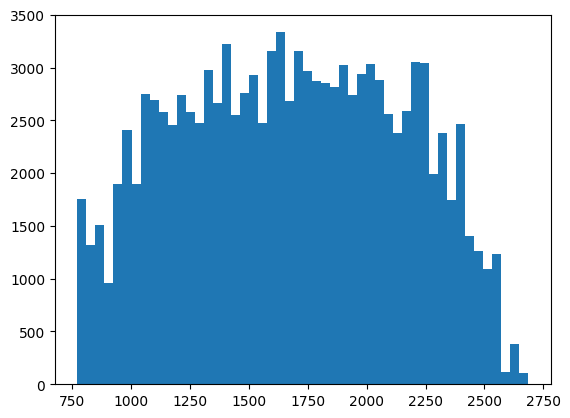

In [16]:
import pandas as pd

df = pd.DataFrame(Oy1)
print(df.describe())

df = pd.DataFrame(y1)
print(df.describe())

#plot the distribution of the ratings
import matplotlib.pyplot as plt

plt.hist(Oy1,bins=50)

In [85]:
len(tf.keras.utils.to_categorical(y1,num_classes=48))

IndexError: index 1950 is out of bounds for axis 1 with size 48

In [78]:
y1.shape

(115872,)